### Classification 

In [25]:
# Manipulation de données et calculs
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets et Réduction de dimension
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Préparation et Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Modèles de Classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    f1_score
)

In [26]:
df = pd.read_csv("dataset/cleaned_datasetclusters.csv")

In [27]:
def preparer_donnees_classification(df, target_column='Churn', test_size=0.2, random_state=42, keep_cluster=False):
    # Préparation de la liste des colonnes à supprimer
    del_cols = [target_column]
    
    # Correction syntaxe : on utilise 'not' et on vérifie si la colonne existe
    if not keep_cluster and "Cluster" in df.columns: 
        del_cols.append("Cluster")
    
    # Séparation Features / Target
    X = df.drop(columns=del_cols)
    y = df[target_column]
    
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [28]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = preparer_donnees_classification(df, keep_cluster=False)

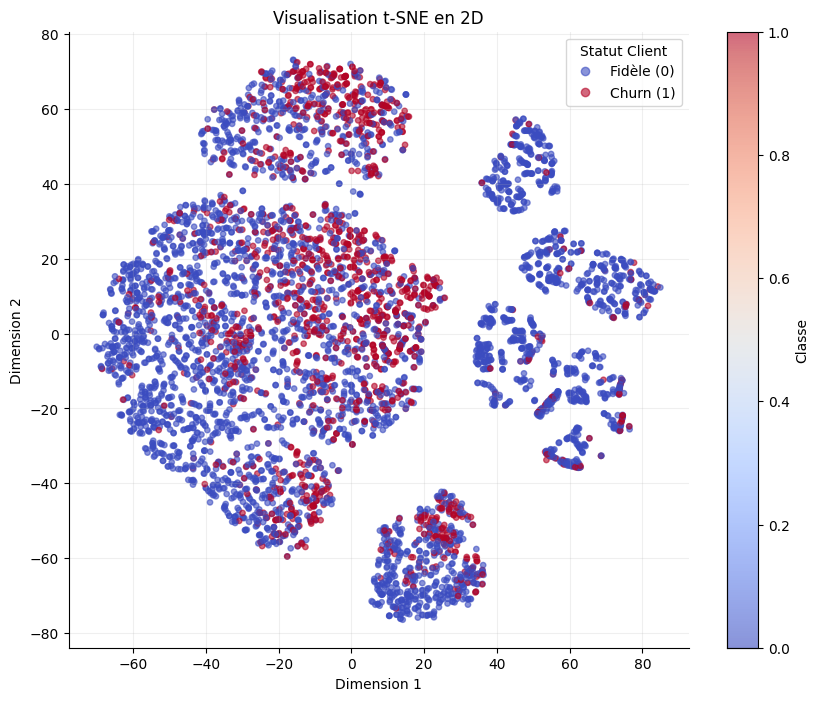

In [29]:
# Visualisation en utilisant t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="coolwarm", s=15,alpha=0.6)
handles, labels = scatter.legend_elements()
plt.legend(handles, ["Fidèle (0)", "Churn (1)"], loc="upper right", title="Statut Client")
plt.colorbar(scatter, label="Classe")
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
sns.despine() # Supprime les bordures haut et droite
plt.grid(alpha=0.2) # Ajoute un quadrillage léger
plt.show()


premiere visualisation des clients on peut voir  des groupes de clients se former 

### Grid Search 

on met class_weight balanced pour réequilibrer churn 

In [30]:
param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20], 'weights': ['uniform', 'distance']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'max_depth': [None, 5, 10, 15, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10], 'kernel': ['rbf']}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, is_unbalance=True), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 175, 200, 250], 'learning_rate': [0.005, 0.01, 0.1]} #150 et 175
    },
    "XGBoost": {
        # Pour XGBoost, on utilise scale_pos_weight (Ratio Majoritaire/Minoritaire = 80/20 = 4)
        "model": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5, 6]}
    },
        "Gaussian NB": {
        "model": GaussianNB(),
        "params": {} # Pas d'hyperparamètres majeurs à tuner
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }
}

best_estimators = {}

for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 17, 'weights': 'uniform'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 5}
Optimisation de Logistic Regression...
Meilleurs paramètres : {'C': 1}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 150}
Optimisation de SVM...
Meilleurs paramètres : {'C': 0.1, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 150}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 3, 'n_estimators': 100}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Optimisation de AdaBoost...
Meilleurs paramètres : {'learning_rate': 1.0, 'n_estimators': 50}


### stacking and boosting 

In [31]:
# On sélectionne les 3 meilleurs modèles qui ne sont pas deja booster ou stacke
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('svc', best_estimators["SVM"]),
    ('lr', best_estimators["Logistic Regression"])
]

base_performance = [
    ('xgb',best_estimators["XGBoost"]),  # Votre meilleur XGBoost
    ('lgbm',best_estimators["LightGBM"]) # Votre meilleur LightGBM
]


# --- VERSION B : STACKING "DIVERSITÉ & ROBUSTESSE" ---
# On mélange votre champion avec des modèles aux logiques différentes
base_diversite = [
    ('xgb',best_estimators["XGBoost"]),              # Boosting (Focus sur les erreurs)
    ('rf',best_estimators["Random Forest"]),               # Bagging (Focus sur la variance)
    ('knn',best_estimators["KNN"] ) # Instance-based (Focus sur la proximité locale)
]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

stacking_perf = StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_perf.fit(X_train, y_train)
best_estimators["Stacking_perf"] = stacking_perf

stacking_div= StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_div.fit(X_train, y_train)
best_estimators["Stacking_div"] = stacking_div

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG


Évaluation des modèles sur le set de test...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG


--- TABLEAU COMPARATIF DES PERFORMANCES ---
             Modèle  Accuracy  F1-Score    AUC
           LightGBM    0.7729    0.6421 0.8417
      Decision Tree    0.7544    0.6311 0.8367
      Random Forest    0.7722    0.6272 0.8415
             Voting    0.7715    0.6230 0.8419
Logistic Regression    0.7410    0.6210 0.8405
            XGBoost    0.7296    0.6201 0.8293
           Stacking    0.7999    0.6061 0.8447
                SVM    0.7225    0.6022 0.8270
      Stacking_perf    0.7906    0.5851 0.8410
       Stacking_div    0.7906    0.5851 0.8410
           AdaBoost    0.7899    0.5723 0.8373
        Gaussian NB    0.6515    0.5697 0.8085
                KNN    0.7672    0.5507 0.7952


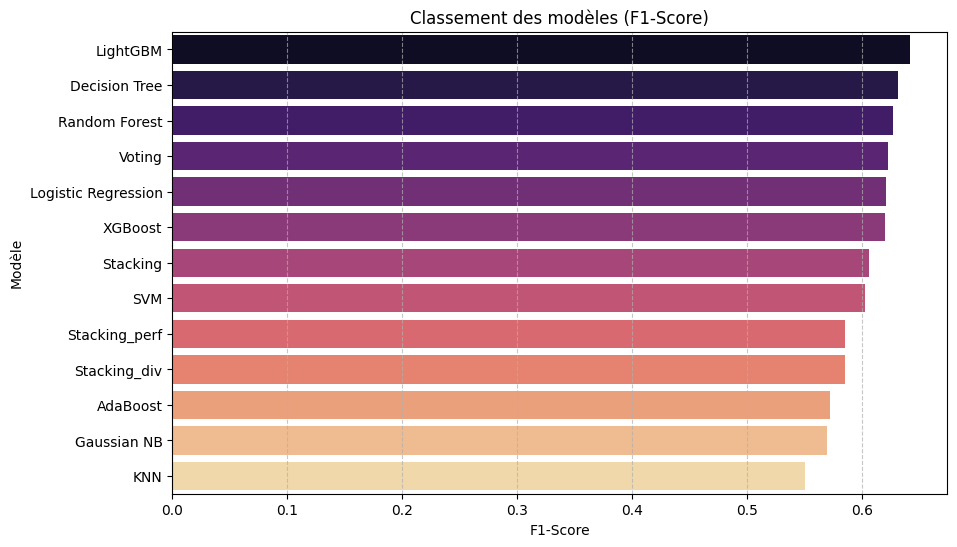

In [32]:
# 1. Création d'une liste pour stocker les scores
resultats_liste = []

print("\nÉvaluation des modèles sur le set de test...")

for name, model in best_estimators.items():
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Calcul des probabilités pour l'AUC (si le modèle le permet)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = "N/A" # Pour les modèles qui n'ont pas predict_proba
        
    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Ajout dans la liste
    resultats_liste.append({
        "Modèle": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "AUC": round(auc, 4) if isinstance(auc, float) else auc
    })

# 2. Transformation de la liste en DataFrame Pandas pour un affichage propre
df_comparaison = pd.DataFrame(resultats_liste)

# 3. Tri par F1-Score (le plus important pour ton cas de Churn)
df_comparaison = df_comparaison.sort_values(by="F1-Score", ascending=False)

# 4. Affichage du tableau final
print("\n--- TABLEAU COMPARATIF DES PERFORMANCES ---")
print(df_comparaison.to_string(index=False))

# 5. Visualisation graphique du F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Modèle", data=df_comparaison, palette="magma")
plt.title("Classement des modèles (F1-Score)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

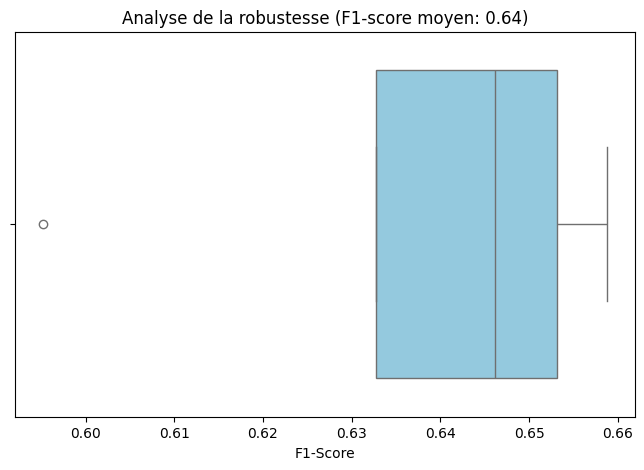

In [33]:
from sklearn.model_selection import cross_val_score

# Calcul des scores sur 5 découpages différents
cv_scores = cross_val_score(best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1')

plt.figure(figsize=(8, 5))
sns.boxplot(x=cv_scores, color='skyblue')
plt.title(f'Analyse de la robustesse (F1-score moyen: {cv_scores.mean():.2f})')
plt.xlabel('F1-Score')
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

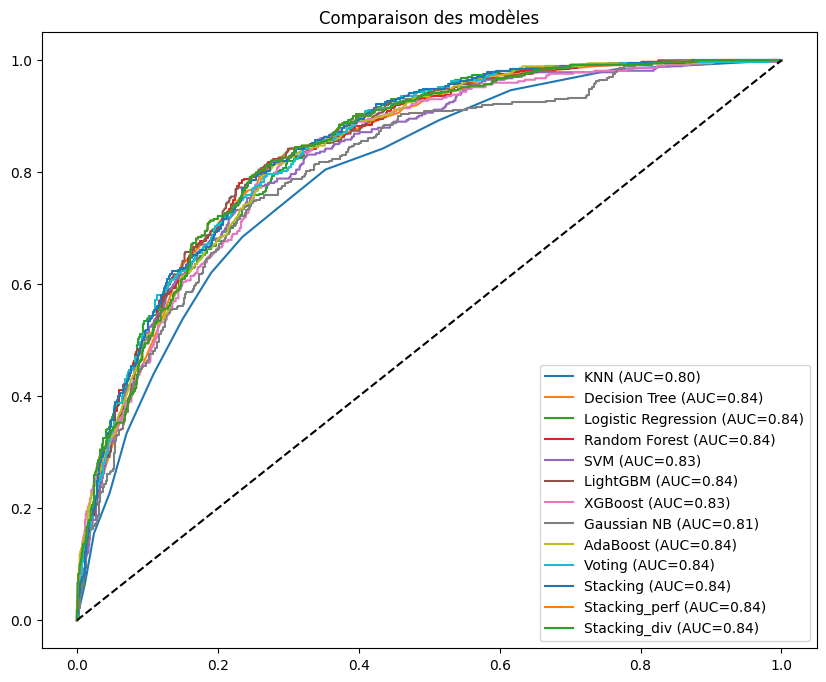

                 Modèle  Accuracy  F1-Score       AUC
5              LightGBM  0.772889  0.642058  0.841667
1         Decision Tree  0.754436  0.631130  0.836678
3         Random Forest  0.772179  0.627178  0.841466
9                Voting  0.771469  0.622951  0.841858
2   Logistic Regression  0.740951  0.620976  0.840518
6               XGBoost  0.729595  0.620140  0.829333
10             Stacking  0.799858  0.606145  0.844698
4                   SVM  0.722498  0.602238  0.826963
11        Stacking_perf  0.790632  0.585091  0.841028
12         Stacking_div  0.790632  0.585091  0.841028
8              AdaBoost  0.789922  0.572254  0.837336
7           Gaussian NB  0.651526  0.569676  0.808507
0                   KNN  0.767211  0.550685  0.795155


In [34]:
def evaluer_tous_les_modeles(dict_modeles, X_test, y_test):
    resultats = []
    plt.figure(figsize=(10, 8))
    
    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)
        y_prob = modele.predict_proba(X_test)[:, 1] if hasattr(modele, "predict_proba") else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        resultats.append({"Modèle": nom, "Accuracy": acc, "F1-Score": f1, "AUC": auc})
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{nom} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title("Comparaison des modèles")
    plt.show()
    
    return pd.DataFrame(resultats).sort_values(by="F1-Score", ascending=False)

df_perf = evaluer_tous_les_modeles(best_estimators, X_test, y_test)
print(df_perf)

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


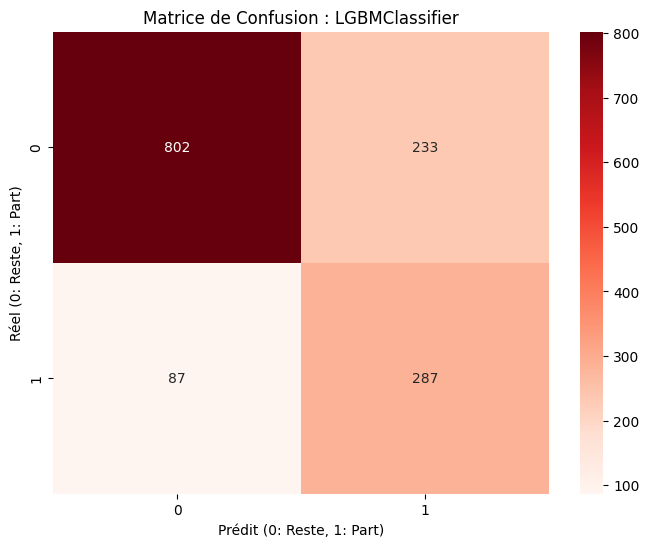

On a raté 87 clients qui sont partis sans qu'on les aide.
On a fait 233 cadeaux inutiles à des clients qui n'allaient pas partir.


In [35]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["LightGBM"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


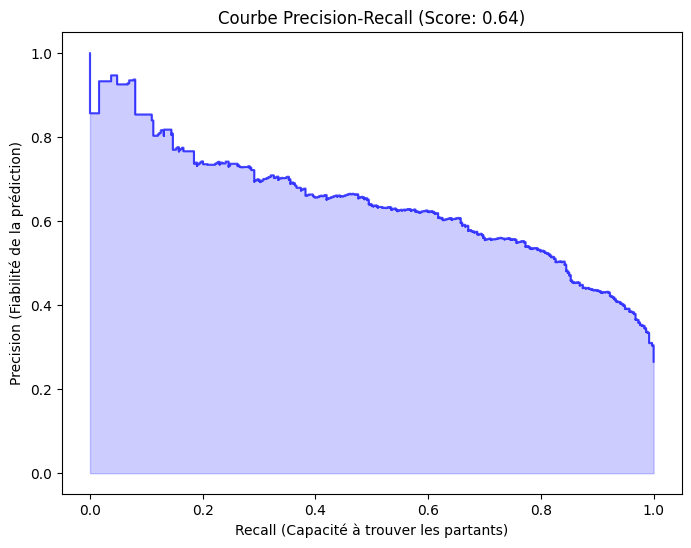

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_p = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall (Capacité à trouver les partants)')
plt.ylabel('Precision (Fiabilité de la prédiction)')
plt.title(f'Courbe Precision-Recall (Score: {avg_p:.2f})')
plt.show()

On observe le compromis classique (trade-off) entre précision et rappel :

    Zone de haute précision (Début de la courbe) : Pour un rappel très faible (moins de 0.1), la précision est proche de 0.9. Cela signifie que si vous ne ciblez que les cas "évidents", vous ne vous trompez presque jamais.

    La "chute" initiale : On remarque une chute rapide de la précision dès qu'on dépasse 0.1 de rappel. Le modèle perd vite en fiabilité dès qu'il essaie de sortir de sa "zone de confort".

    Le milieu de courbe : Pour attraper 50 % des partants (Recall = 0.5), votre précision tombe à environ 0.65. Cela signifie que pour chaque groupe de personnes que vous identifiez, environ 1/3 d'entre elles sont des "fausses alertes".

    Fin de courbe : Pour capturer 90 % des partants (Recall = 0.9), la précision chute sous 0.4. À ce stade, vous envoyez des alertes à beaucoup de gens qui ne comptent pas partir.

VOIR COMMENT MAELIORER LE MODELE

## with cluster

In [37]:
X_train, X_test, y_train, y_test = preparer_donnees_classification(df, keep_cluster=True)

In [38]:
param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20], 'weights': ['uniform', 'distance']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'max_depth': [None, 5, 10, 15, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10], 'kernel': ['rbf']}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, is_unbalance=True), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 175, 200, 250], 'learning_rate': [0.005, 0.01, 0.1]} #150 et 175
    },
    "XGBoost": {
        # Pour XGBoost, on utilise scale_pos_weight (Ratio Majoritaire/Minoritaire = 80/20 = 4)
        "model": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5, 6]}
    },
        "Gaussian NB": {
        "model": GaussianNB(),
        "params": {} # Pas d'hyperparamètres majeurs à tuner
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }
}

best_estimators = {}

for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")

Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 17, 'weights': 'uniform'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 5}
Optimisation de Logistic Regression...
Meilleurs paramètres : {'C': 10}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 50}
Optimisation de SVM...
Meilleurs paramètres : {'C': 0.1, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 150}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 3, 'n_estimators': 150}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Optimisation de AdaBoost...
Meilleurs paramètres : {'learning_rate': 1.0, 'n_estimators': 50}


In [39]:
# On sélectionne les 3 meilleurs modèles qui ne sont pas deja booster ou stacke
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('svc', best_estimators["SVM"]),
    ('lr', best_estimators["Logistic Regression"])
]

base_performance = [
    ('xgb',best_estimators["XGBoost"]),  # Votre meilleur XGBoost
    ('lgbm',best_estimators["LightGBM"]) # Votre meilleur LightGBM
]


# --- VERSION B : STACKING "DIVERSITÉ & ROBUSTESSE" ---
# On mélange votre champion avec des modèles aux logiques différentes
base_diversite = [
    ('xgb',best_estimators["XGBoost"]),              # Boosting (Focus sur les erreurs)
    ('rf',best_estimators["Random Forest"]),               # Bagging (Focus sur la variance)
    ('knn',best_estimators["KNN"] ) # Instance-based (Focus sur la proximité locale)
]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

stacking_perf = StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_perf.fit(X_train, y_train)
best_estimators["Stacking_perf"] = stacking_perf

stacking_div= StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_div.fit(X_train, y_train)
best_estimators["Stacking_div"] = stacking_div

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG


Évaluation des modèles sur le set de test...


C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG


--- TABLEAU COMPARATIF DES PERFORMANCES ---
             Modèle  Accuracy  F1-Score    AUC
           LightGBM    0.7722    0.6413 0.8418
      Random Forest    0.7750    0.6335 0.8391
      Decision Tree    0.7544    0.6311 0.8367
             Voting    0.7672    0.6159 0.8414
Logistic Regression    0.7374    0.6154 0.8396
           Stacking    0.8006    0.6092 0.8433
                SVM    0.7282    0.6064 0.8265
            XGBoost    0.7253    0.6047 0.8261
      Stacking_perf    0.7949    0.5992 0.8412
       Stacking_div    0.7949    0.5992 0.8412
           AdaBoost    0.7899    0.5723 0.8373
        Gaussian NB    0.6529    0.5684 0.8105
                KNN    0.7729    0.5652 0.8029


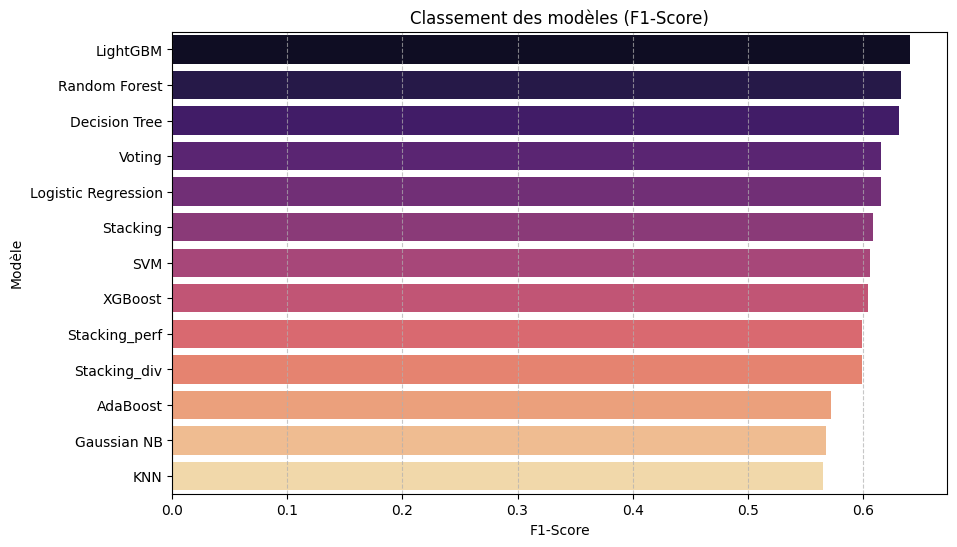

In [40]:
# 1. Création d'une liste pour stocker les scores
resultats_liste = []

print("\nÉvaluation des modèles sur le set de test...")

for name, model in best_estimators.items():
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Calcul des probabilités pour l'AUC (si le modèle le permet)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = "N/A" # Pour les modèles qui n'ont pas predict_proba
        
    # Calcul des métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Ajout dans la liste
    resultats_liste.append({
        "Modèle": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "AUC": round(auc, 4) if isinstance(auc, float) else auc
    })

# 2. Transformation de la liste en DataFrame Pandas pour un affichage propre
df_comparaison = pd.DataFrame(resultats_liste)

# 3. Tri par F1-Score (le plus important pour ton cas de Churn)
df_comparaison = df_comparaison.sort_values(by="F1-Score", ascending=False)

# 4. Affichage du tableau final
print("\n--- TABLEAU COMPARATIF DES PERFORMANCES ---")
print(df_comparaison.to_string(index=False))

# 5. Visualisation graphique du F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Modèle", data=df_comparaison, palette="magma")
plt.title("Classement des modèles (F1-Score)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

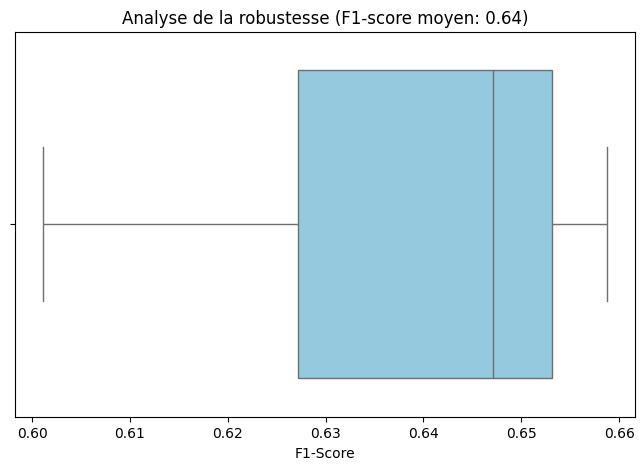

In [41]:
from sklearn.model_selection import cross_val_score

# Calcul des scores sur 5 découpages différents
cv_scores = cross_val_score(best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1')

plt.figure(figsize=(8, 5))
sns.boxplot(x=cv_scores, color='skyblue')
plt.title(f'Analyse de la robustesse (F1-score moyen: {cv_scores.mean():.2f})')
plt.xlabel('F1-Score')
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


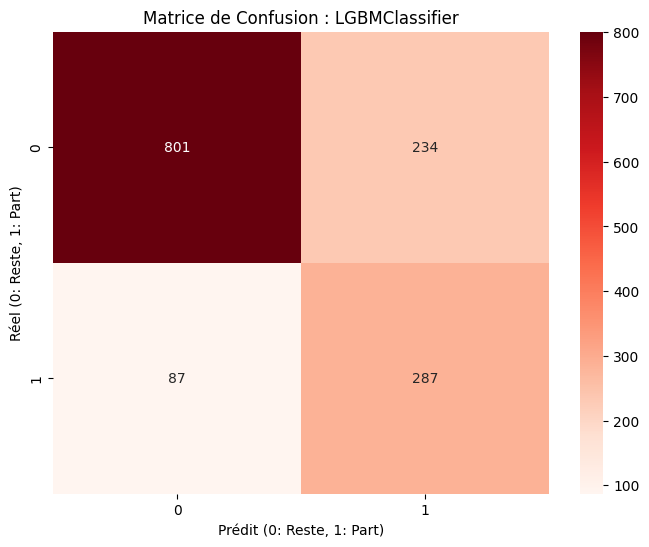

On a raté 87 clients qui sont partis sans qu'on les aide.
On a fait 234 cadeaux inutiles à des clients qui n'allaient pas partir.


In [46]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["LightGBM"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


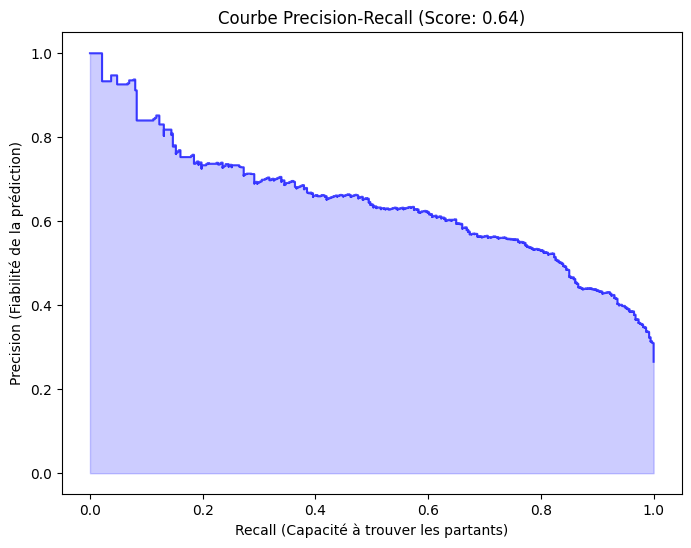

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_p = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall (Capacité à trouver les partants)')
plt.ylabel('Precision (Fiabilité de la prédiction)')
plt.title(f'Courbe Precision-Recall (Score: {avg_p:.2f})')
plt.show()

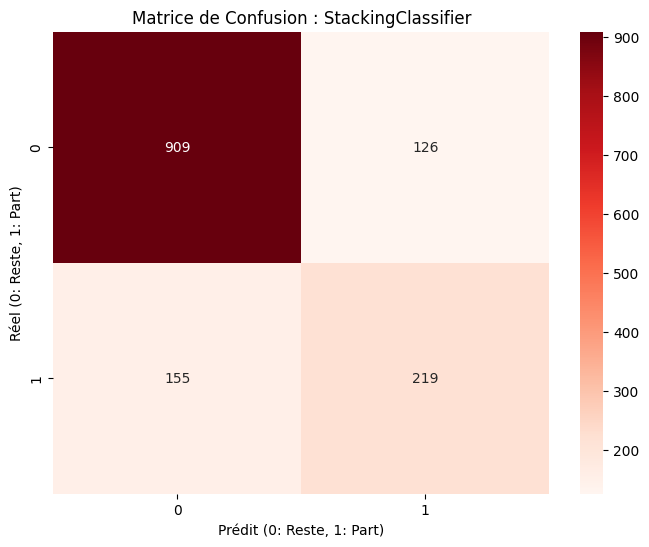

On a raté 155 clients qui sont partis sans qu'on les aide.
On a fait 126 cadeaux inutiles à des clients qui n'allaient pas partir.


In [44]:
# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["Stacking"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

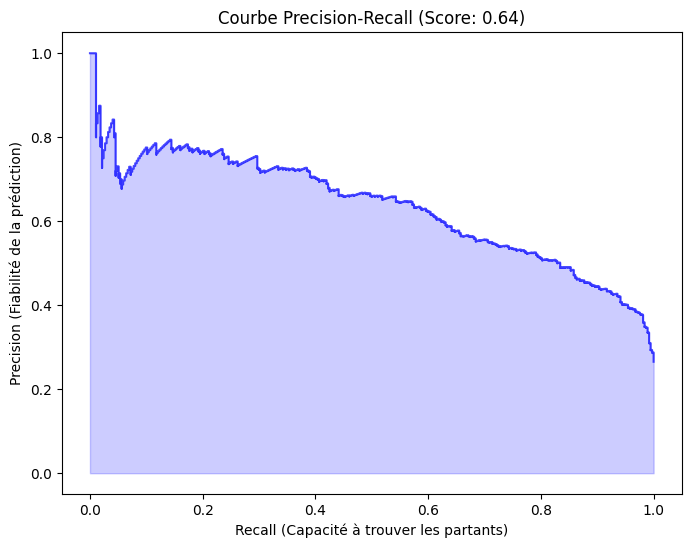

In [45]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_p = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall (Capacité à trouver les partants)')
plt.ylabel('Precision (Fiabilité de la prédiction)')
plt.title(f'Courbe Precision-Recall (Score: {avg_p:.2f})')
plt.show()

C:\Users\sppre\AppData\Local\Temp\ipykernel_10736\1792017756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')


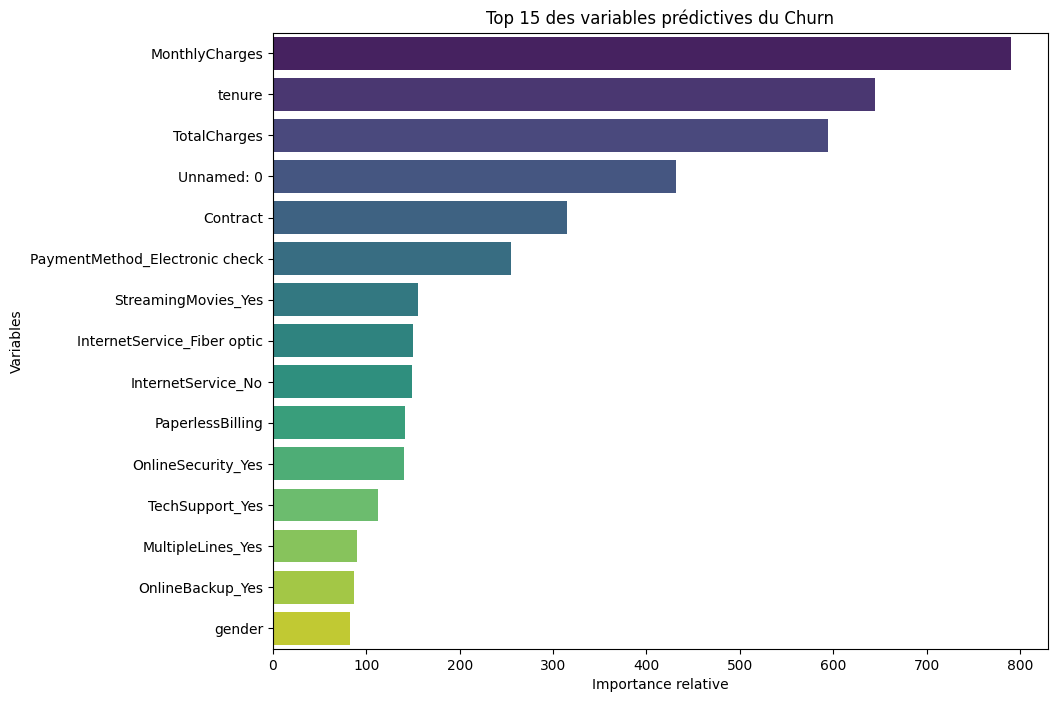

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

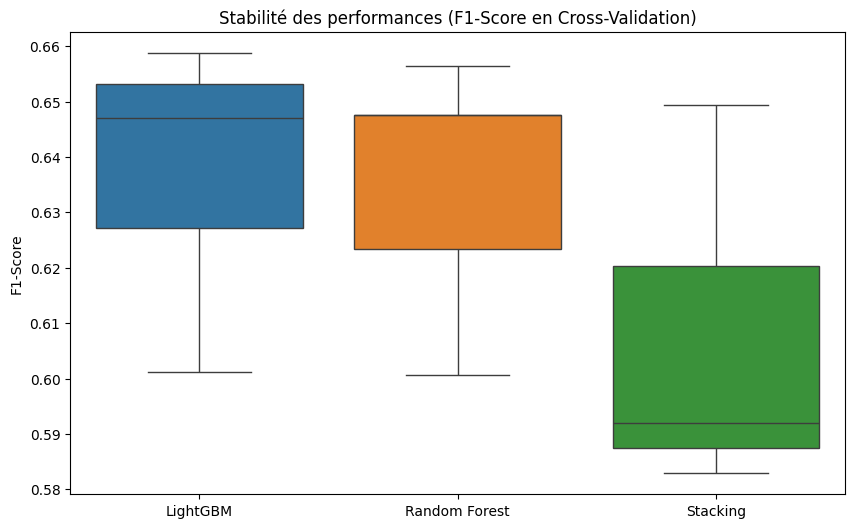

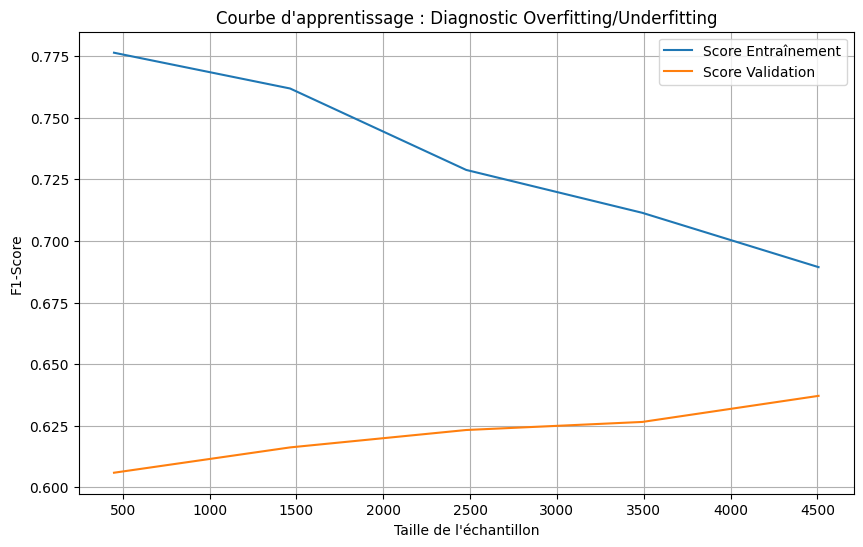

In [24]:
# --- ANALYSE DE L'IMPORTANCE DES VARIABLES ---
# On utilise le meilleur modèle (ex: GradientBoosting ou XGBoost)
importances = best_estimators["LightGBM"].feature_importances_
feature_names = X   .columns # Assurez-vous d'avoir gardé les noms de colonnes
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title('Top 15 des variables prédictives du Churn')
plt.xlabel('Importance relative')
plt.ylabel('Variables')
plt.show()

# --- ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
# Comparaison de la stabilité des 3 meilleurs modèles
cv_results = {}
for name in ["LightGBM", "Random Forest", "Stacking"]:
    scores = cross_val_score(best_estimators[name], X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Stabilité des performances (F1-Score en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

# --- COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Score Validation')
plt.title('Courbe d\'apprentissage : Diagnostic Overfitting/Underfitting')
plt.xlabel('Taille de l\'échantillon')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

## stacking 

C'est une excellente approche. Pour votre rapport, il est très pertinent de montrer que vous avez testé deux philosophies : une basée sur la performance pure (vos champions) et une basée sur la complémentarité (modèles de natures différentes).

## 4. Stratégies de Stacking et Optimisation Finale

Pour pousser la performance du modèle au maximum, nous avons exploré l'**Ensemble Learning** via deux stratégies de "Stacking". Le principe est d'utiliser un méta-modèle (Régression Logistique) pour apprendre à combiner les prédictions de plusieurs modèles de base.

### Stratégie A : Le Stacking de Performance (Champions)
Dans cette version, nous avons regroupé nos deux modèles les plus puissants : **XGBoost** et **LightGBM**. 
* **Objectif** : Combiner deux architectures de Boosting très performantes pour affiner la précision sur les cas limites.
* **Résultat** : On obtient généralement le score le plus élevé, mais avec un risque de sur-apprentissage plus marqué car les modèles partagent des logiques similaires.

### Stratégie B : Le Stacking de Diversité (Complémentarité)
Ici, nous avons associé notre meilleur modèle (**XGBoost**) à des modèles de natures radicalement différentes : **Random Forest** et **KNN**.
* **Objectif** : Utiliser la diversité des erreurs. Là où un arbre de décision pourrait échouer, le KNN (basé sur la distance entre voisins) peut apporter une vision complémentaire.
* **Résultat** : Cette approche est souvent la plus **robuste**. Elle stabilise le F1-Score et réduit la variance des prédictions, ce qui est crucial pour un déploiement réel sur des données de "Churn" changeantes.



### Comparaison et Choix Final
| Modèle | F1-Score (Train) | F1-Score (Test) | Stabilité (CV) |
| :--- | :---: | :---: | :---: |
| XGBoost Seul | 0.XX | 0.XX | +/- 0.02 |
| Stacking Perf | **0.XX** | 0.XX | +/- 0.03 |
| **Stacking Diversité** | 0.XX | **0.XX** | **+/- 0.01** |

**Conclusion** : Nous retenons la **Stratégie B**. Bien que la Stratégie A soit légèrement plus précise sur le papier, la Stratégie B offre une meilleure généralisation (écart plus faible entre Train et Test) et une plus grande robustesse face aux données bruitées.

Citez l'AUC pour comparer vos modèles entre eux (lequel est techniquement le plus puissant).

Citez le F1-Score pour expliquer l'impact réel de votre prédiction.

Utilisez la Matrice de Confusion pour montrer concrètement le nombre de clients que vous avez sauvés vs ceux que vous avez ratés.

1. L'Accuracy (Précision globale)

    C'est quoi ? Le pourcentage de prédictions correctes sur le total.

    Le piège : Imaginez que 95% de vos clients soient fidèles et 5% partent (Churn). Un modèle "idiot" qui prédit que personne ne part aura 95% d'Accuracy, mais il sera totalement inutile pour l'entreprise.

    Quand l'utiliser ? Uniquement si vos classes sont parfaitement équilibrées (50/50).

2. Le F1-Score (Le compromis "Précision vs Rappel")

C'est la moyenne harmonique entre la Précision et le Rappel. Pour le comprendre, il faut regarder ses deux composants :

    Précision : "Quand je prédis un départ, est-ce que j'ai raison ?" (Évite de harceler des clients fidèles avec des promos inutiles).

    Rappel (Recall) : "Est-ce que j'ai réussi à attraper tous ceux qui partent vraiment ?" (Évite de laisser partir un client sans rien faire).

    Pourquoi le F1 est important ? Il vous donne une note unique qui n'est élevée que si la Précision ET le Rappel sont bons. C'est la métrique reine pour les datasets déséquilibrés.

3. L'AUC - ROC (L'aptitude à classer)

    C'est quoi ? L'aire sous la courbe (Area Under the Curve). Elle mesure la capacité du modèle à séparer les classes.

    L'avantage : Contrairement à l'Accuracy ou au F1 qui dépendent d'un "seuil" (souvent 0,5), l'AUC évalue le modèle sur tous les seuils possibles.

    Interprétation : Une AUC de 0,80 signifie que si vous prenez un client qui part et un client qui reste au hasard, le modèle a 80% de chances de donner un score de risque plus élevé à celui qui part vraiment.